In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#



# A Look at Some Broadband 80 Meter Antenna Ideas

It's well known that a standard dipole antenna can't provide a low VSWR over the entire frequency range of the 80 meter band. This notebook looks at some published designs that improve on the dipole's bandwidth. Some of the code presented in previous notebooks is used to optimize antenna geometries and feedline matching arrangements to extract maximum frequency coverage from the designs.

Note that I haven't built or tested any of these antennas - this is merely a demonstration of simulation and optimization.

Thanks to the authors of the various articles referenced herein.



## Baseline for Comparison: A Simple Dipole

Let's look at the characteristics of a simple dipole trimmed for the center of the band (3.75 MHz). In this and subsequent sections I've chosen an arbitrary height of 30 meters (98.4 ft) for the antenna feedpoint.

Half element length (m): 19.67
Impedance at midpoint: [3.75, (94.945-0.15595j)]
Bandwidth for VSWR <= 2.0 (MHz): 0.087


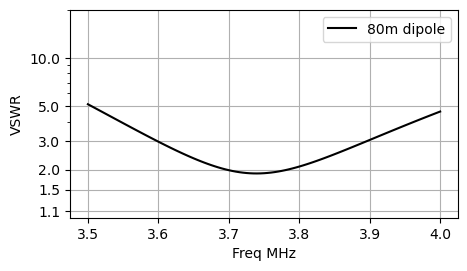

In [1]:
from necutil import nec5_sim_stdio3,plot_vswr,trim_res_freq,find_vswr_bw

# Simple dipole template, height = 30 meters
AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
necstr = """CE Dipole
GW 1 10 0 0 30 0 {len} 30 0.000814
GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {fnum} 0 0 {flow} {fstep}
XQ 0
EN
"""

freq = 3.75
y_est = 142.646 / freq / 2                  # Estimated half-dipole length (m)
y = trim_res_freq(necstr, freq, y_est, tol=0.001)
print(f'Half element length (m): {y:.2f}')

res = nec5_sim_stdio3([necstr.format(len=y, fnum=101, flow=3.5, fstep=0.005)])
zs = res[0][0][0]         # freqs, zs
print(f'Impedance at midpoint: {zs[50]}')
s = necstr.format(len=y, fnum='{fnum}', flow='{flow}', fstep='{fstep}')
bw = find_vswr_bw(s, 2.0, 3.5, 4.0, fnum=11, tol=0.001)
print(f'Bandwidth for VSWR <= 2.0 (MHz): {bw:.3f}')
plot_vswr([zs], tags=['80m dipole'])





## Add Series Section Matching

Next we'll add series section matching to minimize the VSWR at the band's midpoint. This scheme is described in the Regier paper refereced below and in many other sources, e.g.:

* Regier, F., "Impedance Matching  with a Series Transmission Line Section", *Proc. IEEE*, Vol. 59, No. 7, July 1971, pp.1133-1134
* Cebik, L.B. "Series Matching: A Review" [http://www.antentop.org/w4rnl.001/ser.html](http://www.antentop.org/w4rnl.001/ser.html)



In [4]:
zs[50]

[3.75, (94.945-0.15595j)]


![Graph](../Cad/Series_Section_Match_1.svg)



<!-- <img src="../Cad/Series_Section_Match_1.svg" alt="Drawing" style="width: 400px;"/> -->
<img src="../Cad/Series_Section_Match_1.svg" alt="Drawing" />



![Graph](../Cad/Series_Section_Match_1.png)